In [18]:
# Importing libraries for data manipulation
import sqlite3
import pandas as pd

# Importing libraries for data visualization
import matplotlib.pyplot as plt
import numpy as np

# Importing libraries for data preprocessing
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

# Importing libraries for classification
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import classification_report

# Importing libraries for classification models
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.model_selection import GridSearchCV

from py_helpers.pipeline_helper import *
from py_helpers.db_helper import *



In [19]:
"""
Define the list of attributes and table names
Example of how to fetch data from multiple tables
attributes = ["t1.attribute1", "t2.attribute2", "t3.attribute3", "t4.attribute4"] # Any attribute names that we want to fetch
table_names = ["table1", "table2", "table3", "table4"]  # The table names that we want to join
join_conditions = ["t1.id = t2.id", "t1.id = t3.id", "t1.id = t4.id"]  # The join conditions for the tables
"""
"""
# Fetching data from the database
attributes = ["t1.year", "t1.playoff"] # Any attribute names that we want to fetch
table_names = ["teams"]  # The table names that we want to join
join_conditions = []  # The join conditions for the tables

# Removing the table names from attributes
cleaned_attributes = [attr.split('.')[1] for attr in attributes]
"""

'\n# Fetching data from the database\nattributes = ["t1.year", "t1.playoff"] # Any attribute names that we want to fetch\ntable_names = ["teams"]  # The table names that we want to join\njoin_conditions = []  # The join conditions for the tables\n\n# Removing the table names from attributes\ncleaned_attributes = [attr.split(\'.\')[1] for attr in attributes]\n'

In [20]:
df = retrieve_data('./db/WNBA_cleared.db', 'merged')
df.drop(['rank'], axis=1, inplace=True) # to good be true

label_encoder = LabelEncoder()
df['tmID'] = label_encoder.fit_transform(df['tmID'])
#df = df.drop(['tmID'], axis=1)

# Shuffling the DataFrame
df = df.sample(frac=1, random_state=42) 

In [21]:
# Metrics to be used for evaluation of the model performance
metrics =  {
    'accuracy' : accuracy_score    # Accuracy -> bad with unbalanced data
    # 'precision' : precision_score,  # Precision -> good with unbalanced data (high precision means low false positives)
    # 'recall' : recall_score,        # Recall -> good with unbalanced data (high recall means low false negatives)
    # 'f1' : f1_score,                # F1 -> good with unbalanced data (high f1 means low false positives and false negatives)
    # 'roc_auc' : roc_auc_score       # ROC AUC -> good with unbalanced data (high roc auc means low false positives and false negatives)
}

In [22]:
target = 'playoff'  # The target attribute
seed = 42           # The random seed for the train-test split

In [23]:
# Define the pipeline with different models

# Logistic Regression Pipeline Model (model_lr)
model_lr = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(random_state=seed))
])

# Random Forest Pipeline Model (model_rf)
model_rf = Pipeline([
    #('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier(random_state=seed))
])

# Support Vector Machine Pipeline Model (model_svm)
model_svm = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', SVC(random_state=seed))
])

# Gradient Boosting Machine Pipeline Model (model_gb)
model_gb = Pipeline([
    #('scaler', StandardScaler()),
    ('classifier', GradientBoostingClassifier(random_state=seed))
])

# Neural Network Pipeline Model (model_nn)
model_nn = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', MLPClassifier(random_state=seed))
])

# Dictionary of all the models
all_models =  { 'Logistic Regression' : model_lr, 
                'Random Forest' : model_rf, 
                'Support Vector Machine' : model_svm, 
                'Gradient Boosting' : model_gb, 
                'Neural Network' : model_nn
              }

In [24]:
all_results = { 'sliding': [], 'expanding': [] , 'mixed' : []}

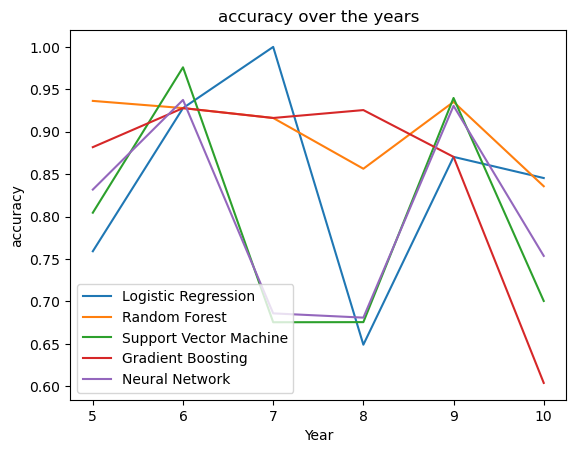

In [25]:
# Sliding window analysis
total_years = 10 # Total number of years that we have data for
window_size = 4 # Maybe test with different window sizes

start = 5

all_results['sliding'] = {}
for model_name, model in all_models.items():
    all_results['sliding'][model_name] = sliding_window_analysis(df, start, total_years, window_size, target, metrics, model)

plot_metrics_for_models(all_results['sliding'], all_models, start, total_years, metrics)

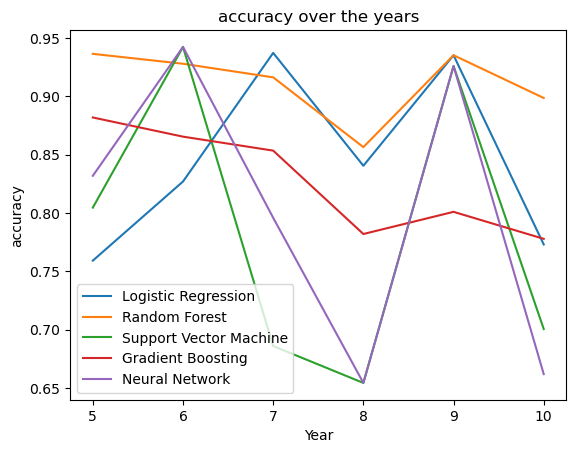

In [26]:
# Expanding window analysis
total_years = 10  # Total number of years that we have data for
start = 5 # Should be higher than 1 because we need to have at least 1 year of training data

all_results['expanding'] = {}
for model_name, model in all_models.items():
    all_results['expanding'][model_name] = expanding_window_analysis(df, start, total_years, target, metrics, model)

plot_metrics_for_models(all_results['expanding'], all_models, start, total_years, metrics)

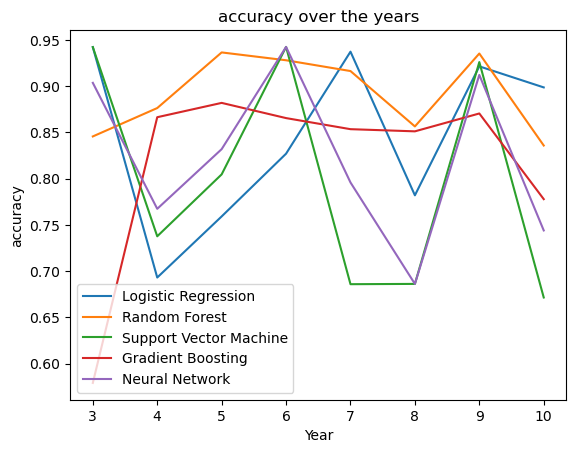

In [27]:
# Mixed window analysis
total_years = 10  # Total number of years that we have data for
start = 3  # Should be higher than 1 because we need to have at least 1 year of training data
start_sliding = 6  # Decide when to start sliding when predicting the 6th year

all_results['mixed'] = {}
for model_name, model in all_models.items():
    all_results['mixed'][model_name] = mixed_window_analysis(df, total_years, start, start_sliding, metrics, model, target)

plot_metrics_for_models(all_results['mixed'], all_models, start, total_years, metrics)

In [28]:
# Logistic Regression Pipeline Model (model_lr)
model_lr = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(random_state=seed))
])

# Random Forest Pipeline Model (model_rf)
model_rf = Pipeline([
    #('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier(random_state=seed))
])

# Support Vector Machine Pipeline Model (model_svm)
model_svm = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', SVC(random_state=seed))
])

# Gradient Boosting Machine Pipeline Model (model_gb)
model_gb = Pipeline([
    #('scaler', StandardScaler()),
    ('classifier', GradientBoostingClassifier(random_state=seed))
])

# Neural Network Pipeline Model (model_nn)
model_nn = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', MLPClassifier(max_iter=500, random_state=seed))  # Increase max_iter
])

tuned_models =  { 'Logistic Regression' : model_lr,
                'Random Forest' : model_rf, 
                'Support Vector Machine' : model_svm, 
                'Gradient Boosting' : model_gb, 
                'Neural Network' : model_nn
              }

In [29]:
# Hyperparameter grids for each model
param_grid_lr = {
    'classifier__penalty': ['l2'],  # Only 'l2' penalty with lbfgs solver
    'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100]  
}

param_grid_rf = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [None, 10, 20, 30],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4]
}


param_grid_svm = {
    'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'classifier__kernel': ['linear', 'rbf', 'poly'],
    'classifier__gamma': ['scale', 'auto']
}

param_grid_gb = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__learning_rate': [0.01, 0.1, 0.2],
    'classifier__max_depth': [3, 5, 7],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4]
}

param_grid_nn = {
    'classifier__hidden_layer_sizes': [(50,), (100,), (50, 50)],
    'classifier__activation': ['relu', 'logistic'],
    'classifier__alpha': [0.0001, 0.001, 0.01],
    'classifier__learning_rate': ['constant', 'adaptive']
}

param_grids = {
    'Logistic Regression': param_grid_lr,
    'Random Forest': param_grid_rf,
    'Support Vector Machine': param_grid_svm,
    'Gradient Boosting': param_grid_gb,
    'Neural Network': param_grid_nn
}

In [30]:
def tune_and_evaluate_model(model_name, pipeline, param_grid, df, start, total_years, window_size, target, window_type='sliding'):
    # Extract metrics for the specified model
    metrics = {'accuracy': accuracy_score}

    # Perform grid search using cross-validation
    grid_search = GridSearchCV(pipeline, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    
    # Perform sliding window analysis and store results
    if (window_type == 'sliding'):
        results = sliding_window_analysis(df, start, total_years, window_size, target, metrics, grid_search)
    elif (window_type == 'expanding'):
        results = expanding_window_analysis(df, start, total_years, target, metrics, grid_search)
    elif (window_type == 'mixed'):
        results = mixed_window_analysis(df, total_years, start, start_sliding, metrics, grid_search, target)

    # Output the best parameters from the grid search
    print(f"Best parameters for {model_name}: {grid_search.best_params_}")

    # Output the mean and standard deviation of accuracy across all windows
    mean_accuracy = np.mean(results['accuracy'])
    std_accuracy = np.std(results['accuracy'])
    print(f"Mean accuracy: {mean_accuracy:.4f}, Standard deviation: {std_accuracy:.4f}")


    return results


Best parameters for Logistic Regression: {'classifier__C': 1, 'classifier__penalty': 'l2'}
Mean accuracy: 0.8427, Standard deviation: 0.1137
Best parameters for Random Forest: {'classifier__max_depth': None, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 50}
Mean accuracy: 0.9119, Standard deviation: 0.0539
Best parameters for Support Vector Machine: {'classifier__C': 0.1, 'classifier__gamma': 'scale', 'classifier__kernel': 'linear'}
Mean accuracy: 0.8365, Standard deviation: 0.1252
Best parameters for Gradient Boosting: {'classifier__learning_rate': 0.01, 'classifier__max_depth': 3, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 50}
Mean accuracy: 0.8333, Standard deviation: 0.1603
Best parameters for Neural Network: {'classifier__activation': 'relu', 'classifier__alpha': 0.01, 'classifier__hidden_layer_sizes': (100,), 'classifier__learning_rate': 'constant'}
Mean accuracy: 0.8174, 

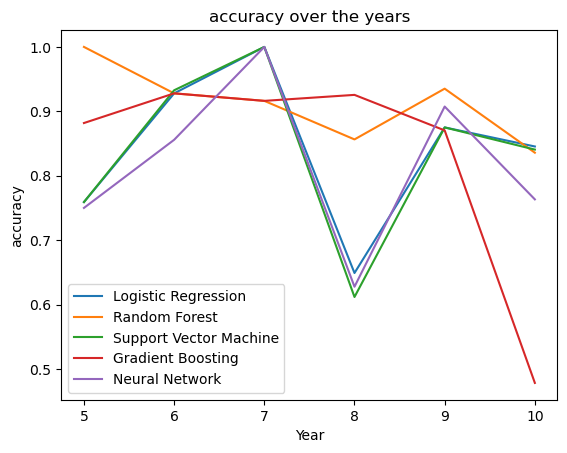

In [31]:
start = 5
window_size = 4

all_results = {}
# Iterate through each model and perform tuning and evaluation
for model_name, pipeline in tuned_models.items():
    param_grid = param_grids[model_name]
    all_results[model_name] = tune_and_evaluate_model(model_name, pipeline, param_grid, df, start, total_years, window_size, target, window_type='sliding')
    
plot_metrics_for_models(all_results, tuned_models, start, total_years, metrics)


/home/malva2312/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/malva2312/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-re

Best parameters for Logistic Regression: {'classifier__C': 10, 'classifier__penalty': 'l2'}
Mean accuracy: 0.8337, Standard deviation: 0.0593
Best parameters for Random Forest: {'classifier__max_depth': None, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 50}
Mean accuracy: 0.9022, Standard deviation: 0.0696
Best parameters for Support Vector Machine: {'classifier__C': 1, 'classifier__gamma': 'scale', 'classifier__kernel': 'linear'}
Mean accuracy: 0.8273, Standard deviation: 0.0617
Best parameters for Gradient Boosting: {'classifier__learning_rate': 0.01, 'classifier__max_depth': 5, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 100}
Mean accuracy: 0.7904, Standard deviation: 0.1735
Best parameters for Neural Network: {'classifier__activation': 'logistic', 'classifier__alpha': 0.01, 'classifier__hidden_layer_sizes': (50,), 'classifier__learning_rate': 'constant'}
Mean accuracy: 0.829

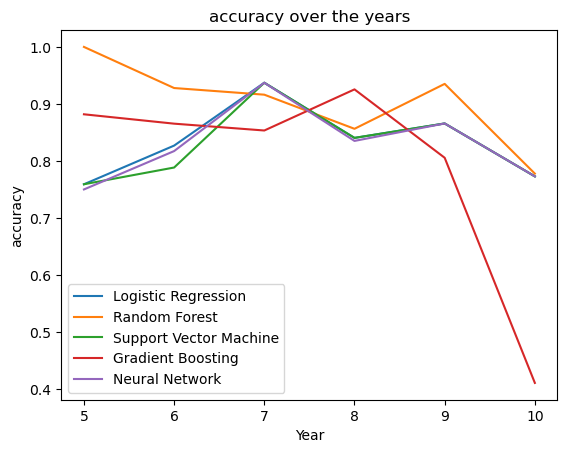

In [32]:
start = 5
window_size = 4

all_results = {}
# Iterate through each model and perform tuning and evaluation
for model_name, pipeline in tuned_models.items():
    param_grid = param_grids[model_name]
    all_results[model_name] = tune_and_evaluate_model(model_name, pipeline, param_grid, df, start, total_years, window_size, target, window_type='expanding')
    
plot_metrics_for_models(all_results, tuned_models, start, total_years, metrics)


/home/malva2312/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/malva2312/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-re

Best parameters for Logistic Regression: {'classifier__C': 10, 'classifier__penalty': 'l2'}
Mean accuracy: 0.8449, Standard deviation: 0.0626
Best parameters for Random Forest: {'classifier__max_depth': None, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 50}
Mean accuracy: 0.9022, Standard deviation: 0.0696
Best parameters for Support Vector Machine: {'classifier__C': 1, 'classifier__gamma': 'scale', 'classifier__kernel': 'linear'}
Mean accuracy: 0.8378, Standard deviation: 0.0567
Best parameters for Gradient Boosting: {'classifier__learning_rate': 0.01, 'classifier__max_depth': 3, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 100}
Mean accuracy: 0.8001, Standard deviation: 0.1443
Best parameters for Neural Network: {'classifier__activation': 'relu', 'classifier__alpha': 0.0001, 'classifier__hidden_layer_sizes': (50,), 'classifier__learning_rate': 'constant'}
Mean accuracy: 0.8279,

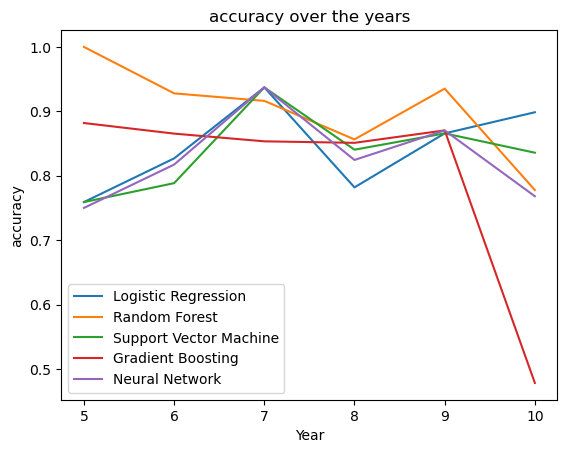

In [33]:
start = 5
window_size = 4

all_results = {}
# Iterate through each model and perform tuning and evaluation
for model_name, pipeline in tuned_models.items():
    param_grid = param_grids[model_name]
    all_results[model_name] = tune_and_evaluate_model(model_name, pipeline, param_grid, df, start, total_years, window_size, target, window_type='mixed')
    
plot_metrics_for_models(all_results, tuned_models, start, total_years, metrics)


In [34]:
# Data from the eleveth year
coaches_csv = '../season_11/coaches.csv'
players_teams_csv = '../season_11/players_teams.csv'
teams_csv = '../season_11/teams.csv'

df_coaches = pd.read_csv(coaches_csv)
df_players_teams = pd.read_csv(players_teams_csv)
df_teams = pd.read_csv(teams_csv)

# Merge the dataframes

# coaches: coachID,year,tmID,lgID,stint
# stint -> c_stint

# players_teams: playerID,year,stint,tmID,lgID
# stint -> p_stint

# teams: year,lgID,tmID,franchID,confID,name,arena

# drop coachID, playerID, franchID, confID, name, arena, lgID

df_11 = pd.merge(df_coaches, df_players_teams, on=['year', 'tmID'], how='inner')
df_11 = pd.merge(df_11, df_teams, on=['year', 'tmID'], how='inner')

df_11['tmID'] = label_encoder.fit_transform(df_11['tmID'])
df_11.head()

,coachID,year,tmID,lgID_x,stint_x,playerID,stint_y,lgID_y,lgID,franchID,confID,name,arena
0,aglerbr99w,11,9,WNBA,0,birdsu01w,0,WNBA,WNBA,SEA,WE,Seattle Storm,KeyArena at Seattle Center
1,aglerbr99w,11,9,WNBA,0,cashsw01w,0,WNBA,WNBA,SEA,WE,Seattle Storm,KeyArena at Seattle Center
2,aglerbr99w,11,9,WNBA,0,ibekwif01w,0,WNBA,WNBA,SEA,WE,Seattle Storm,KeyArena at Seattle Center
3,aglerbr99w,11,9,WNBA,0,jacksla01w,0,WNBA,WNBA,SEA,WE,Seattle Storm,KeyArena at Seattle Center
4,aglerbr99w,11,9,WNBA,0,kobryew01w,0,WNBA,WNBA,SEA,WE,Seattle Storm,KeyArena at Seattle Center


In [35]:


# For each model:
## Predict each year results (maybe year five to year eleven)
### Table with each team and their predicted results for each year

df.head()

,year,tmID,playoff,o_fgm,o_fga,o_ftm,o_fta,o_3pm,o_3pa,o_oreb,...,Sixth_Woman_of_the_Year,WNBA_All_Decade_Team_Honorable_Mention,WNBA_All_Decade_Team,WNBA_Finals_Most_Valuable_Player,totalPoints,cumulativePoints,totalMinutes,yearlyWins,p_stint,c_stint
1344,3,13,0,793,1889,405,538,100,328,292,...,0.0,0.0,0.0,0.0,2091,6398,6400,11,0,1
1934,2,18,1,811,1849,507,675,78,244,295,...,0.0,0.0,0.0,0.0,2207,4620,6475,19,0,1
128,7,1,0,864,2178,552,777,176,544,347,...,0.0,0.0,0.0,0.0,2456,15238,6825,11,0,0
332,1,5,0,868,1980,519,699,76,273,341,...,0.0,0.0,0.0,0.0,2331,2331,6425,14,0,0
1163,4,11,0,825,1923,412,537,181,500,271,...,0.0,0.0,0.0,0.0,2243,8642,6850,16,0,0


In [9]:
predictions = {}
window_size = 3
start = 6
end = 11

models_to_run = [
    'Logistic Regression'
    #'Random Forest',
    #'Support Vector Machine',
    #'Neural Network'
]

for model_name, pipeline in tuned_models.items():
    if (model_name not in models_to_run):
        continue

    model_results = {} # Year -> [Data, Result, Predictions]
    w_size = 0
    for year in range(start, end + 1):
        # if side less than window size, expand window
        if (w_size < window_size):
            w_size += 1

        df_train = df[(df['year'] <= year - 1) & (df['year'] >= year - w_size)]
        df_test = df[df['year'] == year]
        if (year == 11):
            df_test = df_11

        print(year, df_train.shape, df_test.shape)
        X_train = df_train.drop(['playoff'], axis=1)
        y_train = df_train['playoff']

        if (year != 11):
            X_test = df_test.drop(['playoff'], axis=1)
            y_test = df_test['playoff']


        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)

        model_results[year] = [X_test, y_test, y_pred]
    

    # for each team in all teams
    # see the result of the team in each year

    print()

    teams = set()
    results = {} # team, year -> target, prediction
    for year in range(start, end + 1):
        data, target, prediction = model_results[year]
        data['tmID'] = label_encoder.inverse_transform(data['tmID'])
        teams = teams.union(set(data['tmID']))
        for team in teams:
            results[(team, year)] = [target[data['tmID'] == team], prediction[data['tmID'] == team]]
    
    # print it like a table
    table = "\t"
    for i in range(start, end + 1):
        table += str(i) + "\t"
    table += "\n"
    for team in teams:
        table += team + "\t"
        for i in range(start, end + 1):
            target, prediction = results[(team, i)]
            table += str(target) + "\t"
        table += "\n"
    
    print(table)

6 (220, 82) (208, 82)


7 (428, 82) (191, 82)
8 (619, 82) (188, 82)
9 (587, 82) (216, 82)
10 (595, 82) (207, 82)
11 (611, 82) (175, 13)



ValueError: y contains previously unseen labels: [13 15 16 17 19]